## Recognising Goodreads genres- Artificial Intelligence project
Daniela Stern-Gabsi
## EDA -Exploratory Data Analysis

Goodreads is the world’s largest site for readers and book recommendations. https://www.goodreads.com/
It holds millions of books, along with users recommendation, ratings and book descriptions.
Our dataset was built using files from https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/home.
We have limited our task to only books in english, paperback and books having ratings.

Our task is to predict the book genre.
Which can be one of ten categories:
- poetry
- children
- fantasy, paranormal
- history, historical fiction
- comics, graphic
- non-fiction
- mystery, thriller, crime
- young-adult
- romance
- fiction

First we will load the configuration file containing all needed hyperparameters

#### Necessray imports and configuration file loading

In [1]:
#Import necessary packages
import pandas as pd
import os
import yaml

import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import goodreads as gr
import tensorflow as tf
#plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /home/neuralx/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/neuralx/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Important- set seed

In [2]:
SEED=42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
#load configuration file
try:
    with open('configuration.yml', 'r') as file:
        conf = yaml.load(file, Loader=yaml.FullLoader)
except Exception as e:
    print('Error reading the config file')

In [4]:
conf

{'files': {'data_dir': 'data',
  'books_file1': 'goodreads_books_eng_f1.csv',
  'books_file2': 'goodreads_books_eng_f2.csv',
  'image_source_dir': 'data/images-source',
  'images_list': 'books_images_names.csv'},
 'preprocessed': {'preprocess_col_order': ['book_id',
   'work_id',
   'title',
   'num_pages',
   'publication_year',
   'description',
   'is_ebook',
   'series',
   'image_url',
   'read_count',
   'text_reviews_count',
   'ratings_count',
   'average_rating',
   'author_id',
   'name',
   'public_year_null',
   'num_pages_null',
   'authors_ratings_count',
   'author_average_rating',
   'genre'],
  'genres_col': ['poetry',
   'children',
   'fantasy, paranormal',
   'history, historical fiction, biography',
   'comics, graphic',
   'non-fiction',
   'mystery, thriller, crime',
   'young-adult',
   'romance'],
  'full_genres_col': ['poetry',
   'children',
   'fantasy, paranormal',
   'history, historical fiction, biography',
   'comics, graphic',
   'non-fiction',
   'myst

#### Loading the data

In [5]:
books_file1=os.path.join(conf["files"]["data_dir"],conf["files"]["books_file1"])
books_file2=os.path.join(conf["files"]["data_dir"],conf["files"]["books_file2"])
books1=pd.read_csv(books_file1, na_values=['NA', ''])
books2=pd.read_csv(books_file2, na_values=['NA', ''])

books=pd.concat([books1, books2])


Let's look at some statistics first

In [6]:
print(books.info())
print(books.isnull().any())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174342 entries, 0 to 84341
Data columns (total 26 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   Unnamed: 0                              174342 non-null  int64  
 1   book_id                                 174342 non-null  int64  
 2   work_id                                 174342 non-null  float64
 3   title                                   174341 non-null  object 
 4   num_pages                               163463 non-null  float64
 5   publication_year                        170447 non-null  float64
 6   description                             164847 non-null  object 
 7   is_ebook                                174342 non-null  bool   
 8   series                                  174342 non-null  object 
 9   image_url                               174342 non-null  object 
 10  read_count                              17434

In [7]:
books.describe()

,Unnamed: 0,book_id,work_id,num_pages,publication_year,read_count,text_reviews_count,ratings_count,average_rating,author_id,fiction,poetry,children,"fantasy, paranormal","history, historical fiction, biography","comics, graphic",non-fiction,"mystery, thriller, crime",young-adult,romance
count,174342.000000,1.743420e+05,1.743420e+05,163463.000000,170447.000000,174342.000000,174342.000000,174342.000000,174342.000000,1.743420e+05,109767.000000,7507.000000,18418.000000,50867.000000,46871.000000,16687.000000,28965.000000,48528.000000,36279.000000,52797.000000
mean,87170.500000,1.748317e+07,2.503851e+07,270.314744,2010.753924,112.412976,12.985947,106.119036,3.971807,3.951320e+06,313.798610,82.444918,244.772831,419.870093,165.203388,137.564811,98.615156,149.779468,282.646517,114.784003
std,50328.344653,1.014071e+07,1.862190e+07,156.506933,337.184009,1748.592102,94.008291,1692.337680,0.655355,4.472650e+06,1479.746476,372.083776,1086.485785,2399.299955,729.054879,627.113030,550.400455,775.095841,1468.276253,514.906902
min,0.000000,1.000000e+00,6.200000e+01,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,4.000000e+00,-22.000000,-2.000000,-2.000000,-4.000000,-24.000000,-2.000000,-2.000000,-4.000000,-3.000000,-4.000000
25%,43585.250000,1.016884e+07,4.689135e+06,176.000000,2009.000000,2.000000,1.000000,2.000000,3.625000,9.214900e+04,2.000000,1.000000,1.000000,2.000000,2.000000,3.000000,1.000000,2.000000,2.000000,3.000000
50%,87170.500000,1.813799e+07,2.369739e+07,258.000000,2013.000000,7.000000,2.000000,6.000000,4.000000,2.793674e+06,8.000000,3.000000,4.000000,9.000000,9.000000,17.000000,5.000000,7.000000,6.000000,10.000000
75%,130755.750000,2.526960e+07,4.323997e+07,346.000000,2015.000000,24.000000,6.000000,22.000000,4.377778,6.618572e+06,60.000000,17.000000,28.000000,59.000000,54.000000,69.000000,22.000000,45.000000,46.000000,39.000000
max,174341.000000,3.651981e+07,5.836909e+07,14777.000000,65535.000000,196407.000000,10780.000000,191018.000000,5.000000,1.732819e+07,26314.000000,9400.000000,15483.000000,54163.000000,18466.000000,15967.000000,15486.000000,22108.000000,30178.000000,10209.000000


#### Cleaning the data
In order to analyse the data we first will have to clean it.

first we look at publication year and number of pages

<AxesSubplot:>

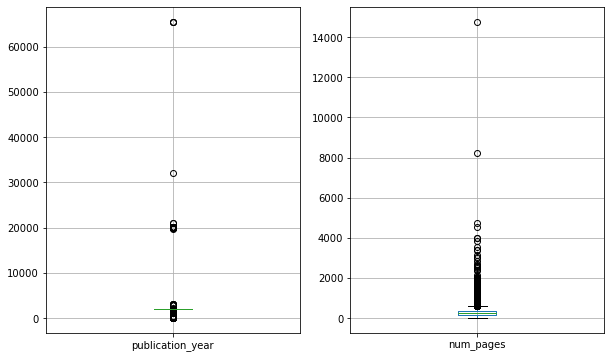

In [8]:
figure, axes = plt.subplots(1,2,figsize=(10,6))

books.boxplot(column=["publication_year"], ax=axes[0])
books.boxplot(column=["num_pages"], ax=axes[1])

We can see that there are outliers which do not make sense

Another problem are null values

In [9]:
books.isnull().sum()

Unnamed: 0                                     0
book_id                                        0
work_id                                        0
title                                          1
num_pages                                  10879
publication_year                            3895
description                                 9495
is_ebook                                       0
series                                         0
image_url                                      0
read_count                                     0
text_reviews_count                             0
ratings_count                                  0
average_rating                                 0
author_id                                      0
name                                           0
fiction                                    64575
poetry                                    166835
children                                  155924
fantasy, paranormal                       123475
history, historical 

Let's look at the label data- the genres

In [10]:
books[["title","name", "fiction","poetry","children","fantasy, paranormal","history, historical fiction, biography",
       "comics, graphic","non-fiction","mystery, thriller, crime","young-adult","romance"]].head(5)

,title,name,fiction,poetry,children,"fantasy, paranormal","history, historical fiction, biography","comics, graphic",non-fiction,"mystery, thriller, crime",young-adult,romance
0,Glimmering Light,Margot Hovley,7.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,3.0,1.0
1,Vision of Sir Launfal and Other Poems,James Russell Lowell,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Understand God's Word - Walk in the Truth,Zhang Yun,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,Faminelands: The Carp's Eye (Book 1),Elizabeth Guizzetti,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
4,Smoke,Catherine McKenzie,96.0,NaN,NaN,NaN,NaN,NaN,2.0,24.0,NaN,3.0


As we can see each genre has number associated to it which represents the "weight" of this genre representing the book.
We will choose as the book genre the genre having the maximum value. But first let us look at genre distribution

<AxesSubplot:>

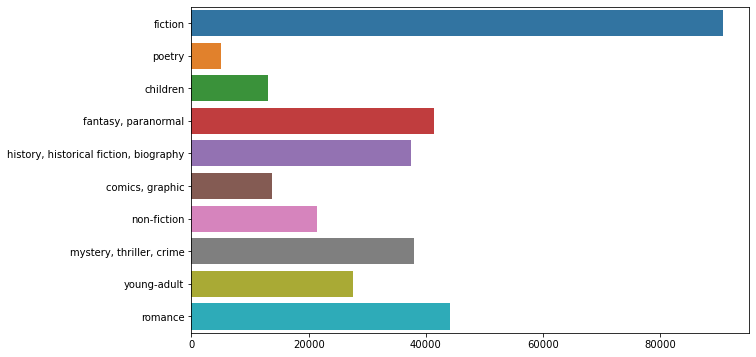

In [11]:
#let's see the distribution of the genres.
genres=books[["fiction","poetry","children","fantasy, paranormal","history, historical fiction, biography",
       "comics, graphic","non-fiction","mystery, thriller, crime","young-adult","romance"]]
figure, axes = plt.subplots(figsize=(10,6))
#set as 1 if genre is positive
bigger_1=(lambda x: 1 if x>1 else 0)
genres_dist=genres.applymap(bigger_1).sum().T
sns.barplot(y=genres_dist.index, x=genres_dist ,ax=axes)

Many of the books are classified as fiction in addition to another genre

Let's look at the ratings distribution

Text(0.5, 0, 'rating')

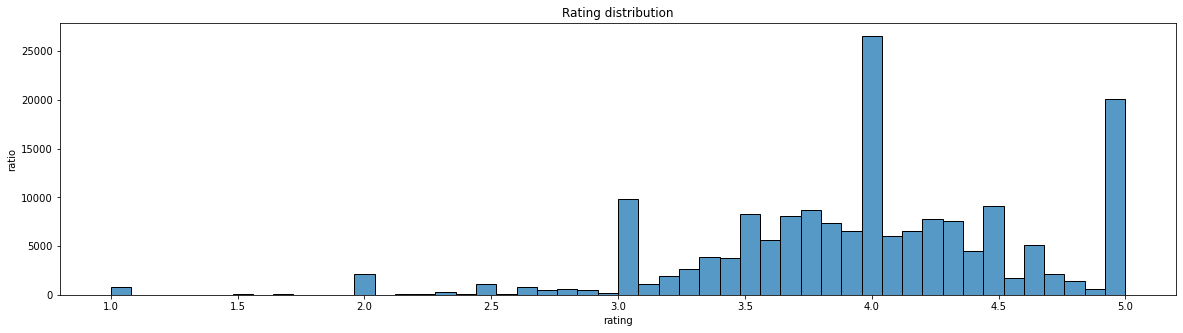

In [12]:
figure, axes = plt.subplots(figsize=(20,5))
sns.histplot(books["average_rating"] ,bins=50, ax=axes)
axes.set_title("Rating distribution")
axes.set_ylabel("ratio")
axes.set_xlabel("rating")

Let us look at some of book titles and book description

In [13]:
books["title"].head()

0                             Glimmering Light
1        Vision of Sir Launfal and Other Poems
2    Understand God's Word - Walk in the Truth
3         Faminelands: The Carp's Eye (Book 1)
4                                        Smoke
Name: title, dtype: object

In [14]:
books["description"].values[2]

'Embrace the word of God with the inspirational book Understand God\'s Word - Walk in the Truth. This powerful look at the Lord\'s instructions and warnings before the day of judgment acts as His trumpet of the time of restoration. It is meant to help people understand God\'s word and follow the path of truth.\nThe Lord opened the first seal and sent His angel on the white horse to lead His army to restore the whole land. He sounded the trumpet and proclaimed that His time of restoration has come.\nThe Lord speaks to the people through the Holy Bible, to make them understand His word. He reveals all His commands to them, to make them walk in the truth. He leads the believers and the churches to repent, to forgive their sins. Ultimately, He is determined to bring back His chosen people and let them enter the kingdom of heaven.\nOrganized into forty different chapters, each chapter is divided into two parts: the first part consists of the Lord\'s instructions and warnings aimed at showin

In [15]:
books["description"].values[4]

"An Amazon Best Book of the Year\nA Goodreads Best Book of the Month\nFrom the internationally bestselling author Catherine McKenzie comes an evocative tale of two women navigating the secrets and lies at the heart of a wildfire threatening their town.\nAfter a decadelong career combating wildfires, Elizabeth has traded in her former life for a quieter one with her husband. Now she works as the local arson investigator in a beautiful, quaint town in the Rockies. But that tranquil life vanishes when she and her husband agree to divorce and a fire in nearby Cooper Basin begins to spread rapidly. For Elizabeth, containing a raging wildfire is easier than accepting that her marriage has failed.\nFor Elizabeth's ex-friend Mindy, who feels disconnected from her husband and teenage children, the fire represents a chance to find a new purpose: helping a man who has lost his home to the blaze. But her faith is shattered by a shocking accusation.\nAs the encroaching inferno threatens the town's 

### Perlimenary preprocess

This  include  handling  of  missing  values  and  outliers.   
It will handle the following:

- Publication year- We omitted any year that was not in the range of 1500-2020 (although thedataset was constructed in 2017 we were more generous..)  and missing values were replaced by the median and added a new boolean feature to indicate this was originally a missing value.
- Number of pages- Although there are some very strong outlier(60,000 pages for a book) we haven’t omitted it because they belong to encyclopedia and therefore seem true.  Zero value swere replaced by nulls and nulls were handled by imputing the median and adding an nullindicator(same as Publication year)
- Genre- Each genre has a number associated to it which can be interpreted as ”weight” of the genre representing the book.  We will label the books genre as the genre having the maximum weight value.  In deciding which genre is the main genre we have not included fiction which is very general .  Only when there is no other genre, then fiction is picked

In [16]:
data_path = os.path.abspath(conf["files"]["data_dir"])
image_source_path = os.path.abspath(conf["files"]["image_source_dir"])
image_source_list = conf["files"]["images_list"]

Creating GoodreadsDataset object for processing the dataset and running a preliminary preprocess

In [17]:
goodr_dataset=gr.GoodreadsDataset(conf['preprocessed'], image_source_path,image_source_list,data_path)
processed_data=goodr_dataset.preprocess(books)

Columns after preprocessing

In [18]:
processed_data.columns

Index(['book_id', 'work_id', 'title', 'num_pages', 'publication_year',
       'description', 'is_ebook', 'series', 'image_url', 'read_count',
       'text_reviews_count', 'ratings_count', 'average_rating', 'author_id',
       'name', 'public_year_null', 'num_pages_null', 'authors_ratings_count',
       'author_average_rating', 'genre'],
      dtype='object')

After handling nulls let us look at most frequent words in the dataset

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(max_features=30, stop_words='english')
word_desc=cv.fit_transform(processed_data["description"].values)

<AxesSubplot:>

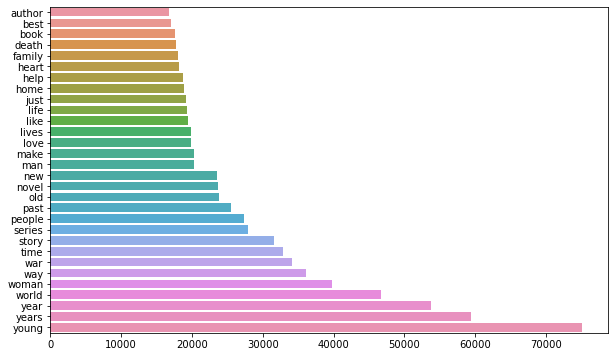

In [20]:
words_df=pd.DataFrame(columns=cv.get_feature_names(), data= (word_desc.toarray().sum(axis=0)).reshape(1,-1))
word_desc=pd.Series(data= (word_desc.toarray().sum(axis=0)), index=cv.get_feature_names())
figure, axes = plt.subplots(figsize=(10,6))
sns.barplot(y=word_desc.index, x=word_desc.sort_values() ,ax=axes)

### Exploring genres data

We will further look at genre labels after preporcessing

<AxesSubplot:>

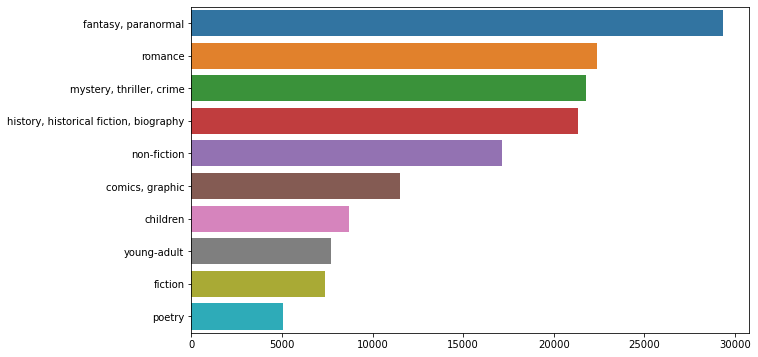

In [21]:
genres_counts=processed_data["genre"].value_counts()
figure, axes = plt.subplots(figsize=(10,6))
sns.barplot(y=genres_counts.index, x=genres_counts.values ,ax=axes)

We can see that the most popular genre is Fantasy. There is some imbalance in the data, but it is not extreme.

Let us look at avarege ratings per genre

<AxesSubplot:xlabel='genre', ylabel='average_rating'>

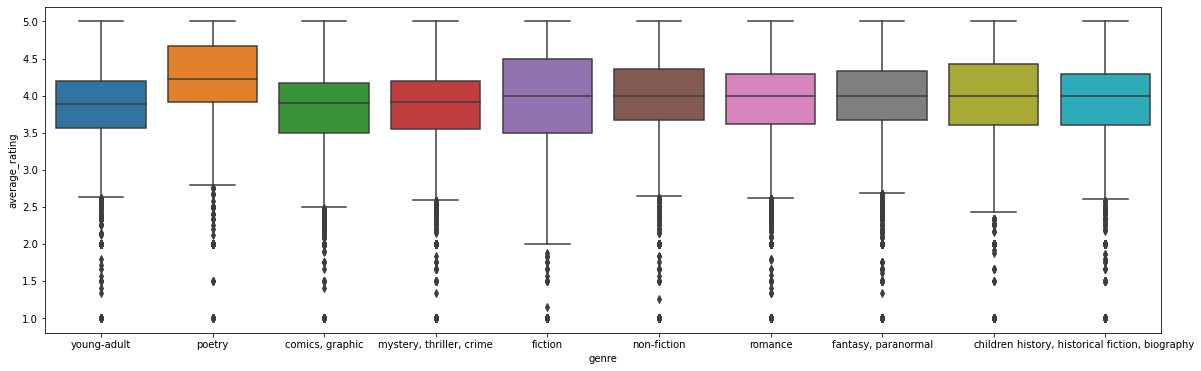

In [22]:
figure, axes = plt.subplots(figsize=(20,6))
books_ratings_genre=processed_data[["average_rating","genre"]]
sns.boxplot(y="average_rating", x="genre", data=books_ratings_genre, ax=axes)

We can see that there is not anything stiking and average_rating might be a good predictor for genre

There are outlier in ratings counts of historical fiction and fantasy

<AxesSubplot:xlabel='genre', ylabel='ratings_count'>

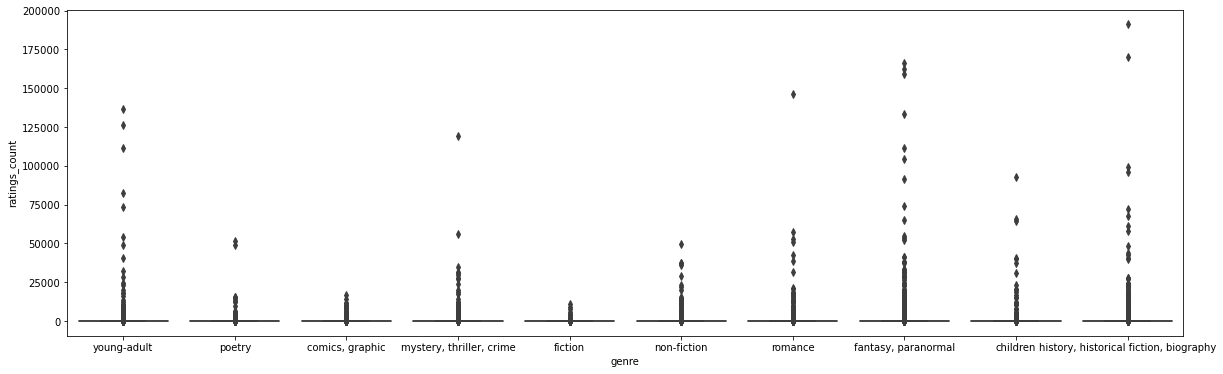

In [23]:
figure, axes = plt.subplots(figsize=(20,6))
books_ratings_genre=processed_data[["ratings_count","genre"]]
sns.boxplot(y="ratings_count", x="genre", data=books_ratings_genre, ax=axes)

#### Exploring authors data

<AxesSubplot:title={'center':'Ten authors with the larget rating counts'}, ylabel='name'>

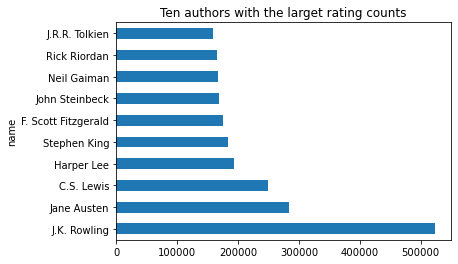

In [24]:
authors_df=processed_data[["name", "authors_ratings_count"]]
authors=authors_df.drop_duplicates()
figure, axes = plt.subplots(figsize=(6,4))
axes.set_title("Ten authors with the larget rating counts")
authors.set_index("name")["authors_ratings_count"].nlargest(10).plot(kind="barh", ax=axes)

### Split the dataset

Split the dataset to train, valdation and tests datasets. This process also prepares our images in correct subfolders

In [25]:
test_pct = conf["test_precentage"]
val_pct = conf["val_precentage"]

In [26]:
print(f"Test precentage (From total dataset) : {test_pct}")
print(f"Validation precentage (From train dataset): {val_pct}")

Test precentage (From total dataset) : 0.1
Validation precentage (From train dataset): 0.1


This might take a while since it prepares all images folders

In [28]:
goodr_dataset.prepare_train_test_split(test_pct=val_pct, val_pct=test_pct, seed=SEED )

Loaded train dataset containing: 123399 samples
Loaded validation dataset containing: 13712 samples
Loaded test dataset containing: 15235 samples
dataset path  /home/neuralx/PycharmProjects/701project/data/images-train
dataset path  /home/neuralx/PycharmProjects/701project/data/images-val
dataset path  /home/neuralx/PycharmProjects/701project/data/images-test
All images prepared in folders
Dataset splits saved as pickle files


Let us now look at some of images of book covers

Found 123399 images belonging to 10 classes.


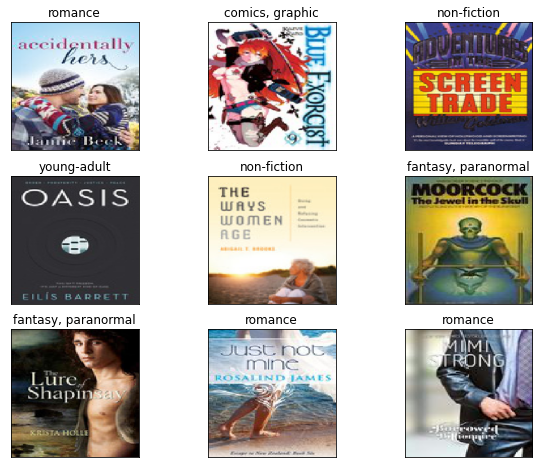

In [35]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(rescale=1. / 255)
train_generator = image_generator.flow_from_directory(
        'data/images-train',
        target_size=(224, 224),
        batch_size=9,
        class_mode='categorical')

labels_list=list(train_generator.class_indices.keys())
        
batch_images=train_generator.next()
fig, axes = plt.subplots(3, 3, subplot_kw={'xticks': (), 'yticks': ()}, figsize=(10, 8))
for images, labels, ax in zip(batch_images[0],batch_images[1], axes.ravel()):
    ax.imshow(images)
    ax.set_title(labels_list[labels.argmax()])